### This script will conduct significance testing of the climate GHD compositing

In [36]:
reset -f

In [37]:
# Setup the Analysis
import calendar
import numpy as np
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from mpl_toolkits.basemap import Basemap, cm

# Embeds plots inside the notebook
%matplotlib inline

# For plotting a rectangle on the maps
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)

# Resampling function
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

In [38]:
# User defined variables
# Years to sample from-I am going to split the analysis into an Early Period and a Later Period
yrs_before = np.arange(1600,1981); yrs_after  = np.arange(1981,2008);

# Rectangle Boundaries for regional averaging
lonmin=-2; lonmax=8; latmin=43; latmax=51

# baseline period for anomaly calculation. Should be same as base period in setp01_proc_ghd.py
base_period = np.arange(1600,1901)   

# User defined variables
# Set threshold GHD anomaly for compositing
harvest_thresh = -7.8;  # about 1 standard deviation for GHDmean or GHD core
#harvest_thresh = -3.9;  # about 1/2 standard deviation for GHDmean or GHD core

# GHD Data to choose
#ghd_name = 'GHDmean'
ghd_name = 'GHDcore'
#ghd_name = 'Bur'

In [39]:
# Load and properly format wine data
infile= '../data/ghd_anom_doy_v02.csv'   # Name of the original data file

df=pd.read_csv(infile)

# Pull out year and mean as float64
yr = np.int64(df.Year)
ghd_mean = np.float64(df[ghd_name])

# Calculate standard deviation over base period
loc=np.where((yr>=np.min(base_period)) & (yr<=np.max(base_period)))[0]
std_ghd = np.nanstd(ghd_mean[loc])

#%%############################################################################
# Load OWDA Data
ncfile_owda = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/OWDA/owda_hd_fix1_500.nc')

# Load OWDA Variables
lat_pdsi=ncfile_owda.variables['lat'][:];
lon_pdsi=ncfile_owda.variables['lon'][:];
yr_pdsi=ncfile_owda.variables['time'][:];
pdsi=ncfile_owda.variables['pdsi'][:];

# Swap PDSI axes so orientation is correct: time, lat, lon
pdsi=np.swapaxes(pdsi,0,2)

ncfile_owda.close

#%%############################################################################
# Load Luterbacher Temp Data
ncfile_luter = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/LUTERTEMP/LuterbacherTemp.nc')

# Load Variables
lat_temp=ncfile_luter.variables['lat'][:];
lon_temp=ncfile_luter.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_luter = np.arange(1,5); seas_luter_all = np.transpose(np.tile(seas_luter,(1,503)))
yr_luter  = np.arange(1500,2003); # yr_luter_all = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# Now, pull out each season individually
tmp_locs = np.where(seas_luter_all==1); tmp_locs = tmp_locs[0]; tmp_DJF = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==2); tmp_locs = tmp_locs[0]; tmp_MAM = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==3); tmp_locs = tmp_locs[0]; tmp_JJA = ncfile_luter.variables['temp'][tmp_locs,0,:,:]
tmp_locs = np.where(seas_luter_all==4); tmp_locs = tmp_locs[0]; tmp_SON = ncfile_luter.variables['temp'][tmp_locs,0,:,:]

ncfile_luter.close

#%%############################################################################
# Load Pauling Precip Data
ncfile_pauling = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/PAULINGPREC/PaulingPrecip.nc')

# Load Variables
lat_prec=ncfile_pauling.variables['lat'][:];
lon_prec=ncfile_pauling.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_paul = np.arange(1,5); seas_paul_all = np.transpose(np.tile(seas_luter,(1,501)))
yr_paul  = np.arange(1500,2001); # yr_luter_all = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# Now, pull out each season individually
pre_locs = np.where(seas_paul_all==1); pre_locs = pre_locs[0]; pre_DJF = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==2); pre_locs = pre_locs[0]; pre_MAM = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==3); pre_locs = pre_locs[0]; pre_JJA = ncfile_pauling.variables['precip'][pre_locs,0,:,:]
pre_locs = np.where(seas_paul_all==4); pre_locs = pre_locs[0]; pre_SON = ncfile_pauling.variables['precip'][pre_locs,0,:,:]

ncfile_pauling.close

<function Dataset.close>

In [40]:
#%%############################################################################
# Anomalize temperature/precipitation data and recenter PDSI to same baseline as GHD anomalies

# Find PDSI years for this period and calculate mean
i_yr_pdsi = np.where( (yr_pdsi>=np.min(base_period)) & (yr_pdsi<=np.max(base_period))); i_yr_pdsi=i_yr_pdsi[0];
# Calculate Mean and recenter PDSI
base_mean_pdsi = np.mean(pdsi[i_yr_pdsi,:,:],axis=0)
pdsi_recenter=pdsi-base_mean_pdsi

# Calculate Mean and Anomalize Temperature
i_yr_temp = np.where( (yr_luter>=np.min(base_period)) & (yr_luter<=np.max(base_period))); i_yr_temp=i_yr_temp[0];
tmp_DJF_mean = np.mean(tmp_DJF[i_yr_temp,:,:],axis=0)
tmp_MAM_mean = np.mean(tmp_MAM[i_yr_temp,:,:],axis=0)
tmp_JJA_mean = np.mean(tmp_JJA[i_yr_temp,:,:],axis=0)
tmp_SON_mean = np.mean(tmp_SON[i_yr_temp,:,:],axis=0)

tmp_DJF_anom = tmp_DJF-tmp_DJF_mean
tmp_MAM_anom = tmp_MAM-tmp_MAM_mean
tmp_JJA_anom = tmp_JJA-tmp_JJA_mean
tmp_SON_anom = tmp_SON-tmp_SON_mean

# Calculate Mean and Anomalize precipitation
i_yr_prec = np.where( (yr_paul>=np.min(base_period)) & (yr_paul<=np.max(base_period))); i_yr_prec=i_yr_prec[0];
pre_DJF_mean = np.mean(pre_DJF[i_yr_prec,:,:],axis=0)
pre_MAM_mean = np.mean(pre_MAM[i_yr_prec,:,:],axis=0)
pre_JJA_mean = np.mean(pre_JJA[i_yr_prec,:,:],axis=0)
pre_SON_mean = np.mean(pre_SON[i_yr_prec,:,:],axis=0)

pre_DJF_anom = pre_DJF-pre_DJF_mean
pre_MAM_anom = pre_MAM-pre_MAM_mean
pre_JJA_anom = ((pre_JJA-pre_JJA_mean)/pre_JJA_mean)*100;
pre_SON_anom = pre_SON-pre_SON_mean


#pre_seas = ((pre_JJA-pre_JJA_mean)/pre_JJA_mean)*100; seas_txt='JJA';




In [41]:
#%%############################################################################
# Calculate regional average PDSI

# Lat and lon indices for the specified region
i_lon_reg=np.where((lon_pdsi>=lonmin) & (lon_pdsi<=lonmax))[0]
i_lat_reg=np.where((lat_pdsi>=latmin) & (lat_pdsi<=latmax))[0]

# Latitude and Longitude Indices for this region
lon_reg = lon_pdsi[i_lon_reg]
lat_reg = lat_pdsi[i_lat_reg]

# Create Latitude Weights
lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)

pdsi_reg_mean=np.zeros(np.size(yr_pdsi))
pdsi_reg_mean_wt=np.zeros(np.size(yr_pdsi))

# Loop Through Each Year
for i in enumerate(yr_pdsi):
    # Pull Correlations From This Region
    region_pdsi = pdsi_recenter[i[0],i_lat_reg,:][:,i_lon_reg]

    # Unweighted and Weighted Means
    pdsi_reg_mean[i[0]]    = np.ma.average(np.ma.masked_invalid(region_pdsi))
    pdsi_reg_mean_wt[i[0]] = np.ma.average(np.ma.masked_invalid(region_pdsi),weights=lat_wts_grid)

#%%############################################################################
# Calculate regional average Temperature

# Lat and lon indices for the specified region
i_lon_reg=np.where((lon_temp>=lonmin) & (lon_temp<=lonmax))[0]
i_lat_reg=np.where((lat_temp>=latmin) & (lat_temp<=latmax))[0]

# Latitude and Longitude Indices for this region
lon_reg = lon_temp[i_lon_reg]
lat_reg = lat_temp[i_lat_reg]

# Create Latitude Weights
lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)

tmpJJA_reg_mean=np.zeros(np.size(yr_luter))
tmpJJA_reg_mean_wt=np.zeros(np.size(yr_luter))

# Loop Through Each Year
for i in enumerate(yr_luter):
    # Pull Correlations From This Region
    region_temp = tmp_JJA_anom[i[0],i_lat_reg,:][:,i_lon_reg]

    # Unweighted and Weighted Means
    tmpJJA_reg_mean[i[0]]    = np.ma.average(np.ma.masked_invalid(region_temp))
    tmpJJA_reg_mean_wt[i[0]] = np.ma.average(np.ma.masked_invalid(region_temp),weights=lat_wts_grid)
    
#%%############################################################################
# Calculate regional average precipitation

# Lat and lon indices for the specified region
i_lon_reg=np.where((lon_prec>=lonmin) & (lon_prec<=lonmax))[0]
i_lat_reg=np.where((lat_prec>=latmin) & (lat_prec<=latmax))[0]

# Latitude and Longitude Indices for this region
lon_reg = lon_prec[i_lon_reg]
lat_reg = lat_prec[i_lat_reg]

# Create Latitude Weights
lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)

preJJA_reg_mean=np.zeros(np.size(yr_paul))
preJJA_reg_mean_wt=np.zeros(np.size(yr_paul))

# Loop Through Each Year
for i in enumerate(yr_paul):
    # Pull Correlations From This Region
    region_prec = pre_JJA_anom[i[0],i_lat_reg,:][:,i_lon_reg]

    # Unweighted and Weighted Means
    preJJA_reg_mean[i[0]]    = np.ma.average(np.ma.masked_invalid(region_prec))
    preJJA_reg_mean_wt[i[0]] = np.ma.average(np.ma.masked_invalid(region_prec),weights=lat_wts_grid)

In [42]:
#%%############################################################################
# Now, find all years that exceed the threshold I set up before
early_yrs = yr[np.where(ghd_mean<=harvest_thresh)]

# Trim to eliminate years before 1600
remove_locs = np.where(early_yrs<1600)[0]
early_yrs = np.delete(early_yrs,remove_locs)

# Find Early Harvest Years that fall within this interval
subset_yrs_before  = np.intersect1d(yrs_before,early_yrs)
subset_yrs_after   = np.intersect1d(yrs_after,early_yrs)

#%%############################################################################
# Split PDSI Series
pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs_before))==1)[0];  pdsi_before = pdsi_reg_mean_wt[pdsi_locs]
print("Early Years Before:")
print(yr_pdsi[pdsi_locs])

pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs_after))==1)[0];   pdsi_after  = pdsi_reg_mean_wt[pdsi_locs]
print("Early Years After:")
print(yr_pdsi[pdsi_locs])

#%%############################################################################
# Boxplot Labels
group_before = (np.str(yrs_before[0])+'-'+np.str(yrs_before[-1]));
group_after  = (np.str(yrs_after[0])+'-'+np.str(yrs_after[-1]));

label_1 = (np.tile(group_before,np.size(pdsi_before)))
label_2 = (np.tile(group_after,np.size(pdsi_after)))

#%%############################################################################
# Mean/Median Statistical Testing
# Initialize Matrix
mean_median_pdsi = np.zeros([3,3])

# Calculate the mean and median PDSI
mean_median_pdsi[0,0] = np.int64(np.size(pdsi_before))
mean_median_pdsi[0,1] = np.int64(np.size(pdsi_after))

mean_median_pdsi[1,0] = np.mean(pdsi_before)
mean_median_pdsi[1,1] = np.mean(pdsi_after)
mean_median_pdsi[1,2] = stats.ttest_ind(pdsi_before, pdsi_after)[1]

mean_median_pdsi[2,0] = np.median(pdsi_before)
mean_median_pdsi[2,1] = np.median(pdsi_after)
mean_median_pdsi[2,2] = stats.ranksums(pdsi_before, pdsi_after)[1]

# Create A DataFrame
col_core_comp_txt=[label_1[0],label_2[0],"Diff, Pval"]
row_core_comp_txt=["n","Mean PDSI","Median PDSI"]
df_pdsi_early_ghd  = pd.DataFrame(mean_median_pdsi, index=row_core_comp_txt, columns=col_core_comp_txt)

df_pdsi_early_ghd


Early Years Before:
[ 1602.  1603.  1604.  1607.  1610.  1611.  1615.  1616.  1619.  1624.
  1630.  1631.  1636.  1637.  1638.  1639.  1644.  1645.  1646.  1651.
  1653.  1657.  1659.  1660.  1661.  1665.  1666.  1668.  1669.  1671.
  1676.  1680.  1681.  1684.  1686.  1706.  1718.  1726.  1788.  1811.
  1822.  1825.  1834.  1846.  1862.  1865.  1868.  1870.  1874.  1893.
  1901.  1904.  1905.  1906.  1911.  1915.  1917.  1921.  1934.  1937.
  1943.  1945.  1947.  1950.  1952.  1959.  1960.  1976.]
Early Years After:
[ 1982.  1989.  1990.  1992.  1993.  1994.  1995.  1997.  1998.  1999.
  2000.  2001.  2002.  2003.  2004.  2005.  2006.  2007.]


,1600-1980,1981-2007,"Diff, Pval"
n,68.000000,18.000000,0.000000
Mean PDSI,-1.049961,0.857061,0.000060
Median PDSI,-0.872573,0.962928,0.000221


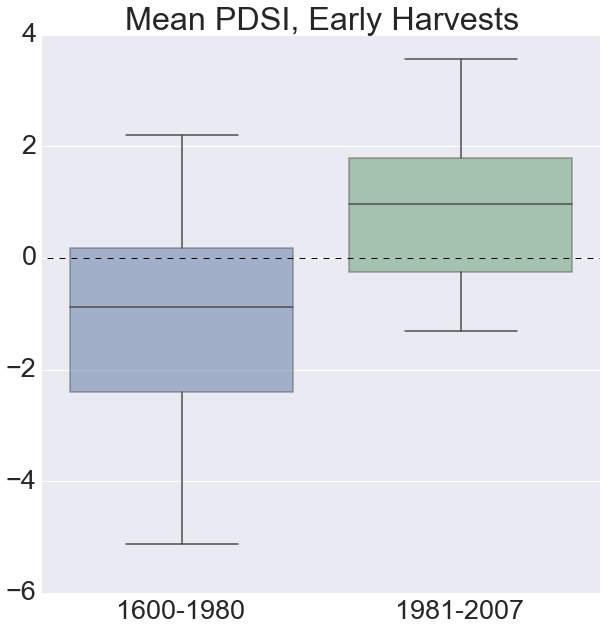

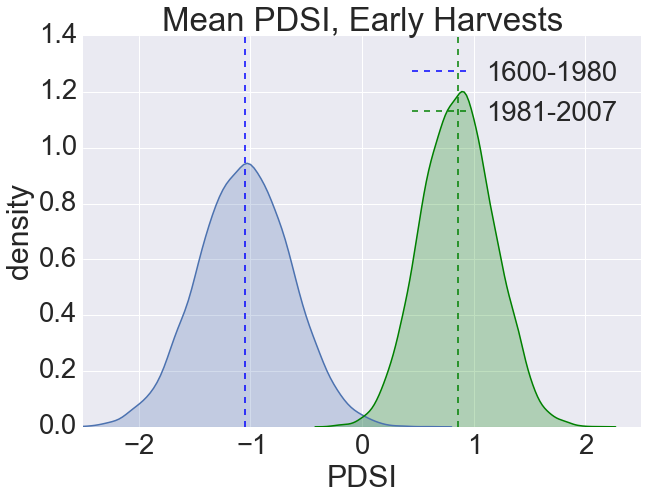

In [43]:
#%%############################################################################
# PDSI Boxplot
sns.plt.close(); sns.set(); 
#sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
sns.set_context("notebook", font_scale=2.7, rc={"lines.linewidth": 1.5})
#fig = sns.plt.figure(figsize=(9,10))
fig = sns.plt.figure(figsize=(10,10))
sns.plt.plot([0,20],[0,0],'--', color='k',linewidth=1)
sns.boxplot([pdsi_before,pdsi_after], labels=[label_1, label_2], names=[group_before,group_after],alpha=0.5);
sns.plt.title('Mean PDSI, Early Harvests')  
sns.plt.tight_layout
sns.plt.savefig('../figures/step05/ghdcore.boxplot.pdsi.'+label_1[0]+'.'+label_2[0]+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 

#%%############################################################################
# Monte-Carlo

# Number of iterations
num_mc = 10000;

# I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
pdsi_resamp_mean_before    = np.zeros(num_mc)
pdsi_resamp_mean_after     = np.zeros(num_mc)
pval_mc_pdsi_ttest2        = np.zeros(num_mc)
pval_mc_pdsi_ranksum       = np.zeros(num_mc)
pval_mc_pdsibefore_onesamp = np.zeros(num_mc)
pval_mc_pdsiafter_onesamp  = np.zeros(num_mc)

# In each iteration, randomly resample (with replacement)
for i in np.arange(0,num_mc):
    
    #print(i)
    # First, Generate resampled PDSI for before and after periods
    pdsi_resamp_before = bootstrap_resample(pdsi_before,np.size(pdsi_after))
    pdsi_resamp_after  = bootstrap_resample(pdsi_after,np.size(pdsi_after))

    # Now, calculate and store the resampled means
    pdsi_resamp_mean_before[i] = np.mean(pdsi_resamp_before)
    pdsi_resamp_mean_after[i] = np.mean(pdsi_resamp_after)

    # Ttest and Ranksum tests
    pval_mc_pdsi_ttest2[i] = stats.ttest_ind(pdsi_resamp_before,pdsi_resamp_after)[1]
    pval_mc_pdsi_ranksum[i] = stats.ranksums(pdsi_resamp_before,pdsi_resamp_after)[1]
    pval_mc_pdsibefore_onesamp[i] = stats.ttest_1samp(pdsi_resamp_before,0)[1]
    pval_mc_pdsiafter_onesamp[i]  = stats.ttest_1samp(pdsi_resamp_after,0)[1]
    
# Kernal Density Function from Monte-Carlo Results
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=2.75, rc={"lines.linewidth": 1.5})
#sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
bins=np.arange(-2.5,1,.125)  
sns.plt.figure(figsize=[10,7])     
sns.kdeplot(pdsi_resamp_mean_before,shade=True)
sns.kdeplot(pdsi_resamp_mean_after,shade=True,color='g')
#sns.plt.hist(pdsi_synth, bins, normed=True, alpha=0.7);
sns.plt.plot([np.mean(pdsi_before),np.mean(pdsi_before)],[0,2],'--', color='b')
sns.plt.plot([np.mean(pdsi_after),np.mean(pdsi_after)],[0,2],'--', color='g')
sns.plt.xlabel('PDSI')
sns.plt.ylabel('density')
sns.plt.title('Mean PDSI, Early Harvests')  
sns.plt.legend(['1600-1980','1981-2007'])
sns.plt.tight_layout
sns.plt.ylim(0,1.4)
sns.plt.xlim(-2.5,2.5)
sns.plt.savefig('../figures/step05/ghdcore.montecarlo.pdsi.'+label_1[0]+'.'+label_2[0]+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 


In [18]:
# Summarize the Monte-Carlo Results

# Percent Simulations Where ttest and ranksum were significantly different
mc_ttest_sig   = np.size(np.where(pval_mc_pdsi_ttest2<=0.05))/np.size(pval_mc_pdsi_ttest2)
mc_ranksum_sig = np.size(np.where(pval_mc_pdsi_ranksum<=0.05))/np.size(pval_mc_pdsi_ranksum)

print('MC ttest='+np.str(mc_ttest_sig))
print('MC ranksum='+np.str(mc_ranksum_sig))

# Initialize Matrix
percentiles_pdsi = np.zeros([2,5])

# Calculate Percentiles from the Monte-Carlo Simulation
percentiles_pdsi[0,:] =np.percentile(pdsi_resamp_mean_before,[1,5,50,95,99])
percentiles_pdsi[1,:] =np.percentile(pdsi_resamp_mean_after,[1,5,50,95,99])

# Create A DataFrame
col_core_comp_txt=["1st","5th","50th","95th","99th"]
row_core_comp_txt=[label_1[0],label_2[0]]
df_pctile_pdsi  = pd.DataFrame(percentiles_pdsi, index=row_core_comp_txt, columns=col_core_comp_txt)

print("PDSI Percentiles, Monte-Carlo")
df_pctile_pdsi

MC ttest=0.9489
MC ranksum=0.8909
PDSI Percentiles, Monte-Carlo


,1st,5th,50th,95th,99th
1600-1980,-2.016234,-1.734210,-1.046326,-0.357649,-0.104906
1981-2007,0.136752,0.337926,0.860847,1.388380,1.604544


In [19]:
#%%############################################################################
# Split Prec Series
prec_locs=np.where(np.int64(np.in1d(yr_paul,subset_yrs_before))==1)[0];  prec_before = preJJA_reg_mean_wt[prec_locs]
print("Early Years Before:")
print(yr_paul[prec_locs])

prec_locs=np.where(np.int64(np.in1d(yr_paul,subset_yrs_after))==1)[0];   prec_after  = preJJA_reg_mean_wt[prec_locs]
print("Early Years After:")
print(yr_paul[prec_locs])

#%%############################################################################
# Boxplot Labels
group_before = (np.str(yrs_before[0])+'-'+np.str(yrs_before[-1]));
group_after  = (np.str(yrs_after[0])+'-'+np.str(yrs_after[-1]));

label_1 = (np.tile(group_before,np.size(prec_before)))
label_2 = (np.tile(group_after,np.size(prec_after)))

#%%############################################################################
# Mean/Median Statistical Testing
# Initialize Matrix
mean_median_prec = np.zeros([3,3])

# Calculate the mean and median PDSI
mean_median_prec[0,0] = np.size(prec_before)
mean_median_prec[0,1] = np.size(prec_after)

mean_median_prec[1,0] = np.mean(prec_before)
mean_median_prec[1,1] = np.mean(prec_after)
mean_median_prec[1,2] = stats.ttest_ind(prec_before, prec_after)[1]

mean_median_prec[2,0] = np.median(prec_before)
mean_median_prec[2,1] = np.median(prec_after)
mean_median_prec[2,2] = stats.ranksums(prec_before, prec_after)[1]

# Create A DataFrame
col_core_comp_txt=[label_1[0],label_2[0],"Diff, Pval"]
row_core_comp_txt=["n","Mean Prec","Median Prec"]
df_prec_early_ghd  = pd.DataFrame(mean_median_prec, index=row_core_comp_txt, columns=col_core_comp_txt)

df_prec_early_ghd



Early Years Before:
[1602 1603 1604 1607 1610 1611 1615 1616 1619 1624 1630 1631 1636 1637 1638
 1639 1644 1645 1646 1651 1653 1657 1659 1660 1661 1665 1666 1668 1669 1671
 1676 1680 1681 1684 1686 1706 1718 1726 1788 1811 1822 1825 1834 1846 1862
 1865 1868 1870 1874 1893 1901 1904 1905 1906 1911 1915 1917 1921 1934 1937
 1943 1945 1947 1950 1952 1959 1960 1976]
Early Years After:
[1982 1989 1990 1992 1993 1994 1995 1997 1998 1999 2000]


,1600-1980,1981-2007,"Diff, Pval"
n,68.000000,11.000000,0.000000
Mean Prec,-11.968008,-1.285384,0.171719
Median Prec,-10.126700,-1.474914,0.364774


In [20]:
print("Prec Before:")
print(prec_before)

print("Prec After:")
print(prec_after)

prec_after[:]

df_prec_before = pd.DataFrame(prec_before)
df_prec_before.to_csv('prec_before.csv',sep=',')

df_prec_after = pd.DataFrame(prec_after)
df_prec_after.to_csv('prec_after.csv',sep=',')

Prec Before:
[  8.75018232 -18.66310444 -12.09838482  -9.70986657   8.20686806
   7.20308776 -37.94489036 -47.32403561  -2.45680082   9.33745675
 -37.01302478 -30.41884367   4.31060144  -4.45570069   2.27161403
  27.0861328   -3.71630677 -15.57964518  -1.99616772   3.11829788
 -20.99984523  -1.1430309   20.80871861 -12.2364533    5.05641391
  23.33517252 -63.00952827  28.72066726 -87.1353121   -9.26708432
 -42.05688265  10.24892683 -58.96682153 -43.98945849   1.1782421
 -70.2851281  -45.65198353 -34.64801541  -4.28857393   1.94167511
  -6.35164421 -23.19032123  17.52323452  -8.23355486   3.17972398
   7.4191068  -12.46357172 -23.59143171 -10.54353389 -16.24592519
 -13.06738777 -17.52746926  12.54083566 -47.70760192 -24.11569192
  -2.33859766  22.91786265 -20.77635143  -3.39920687 -22.19623465
 -10.86290812 -16.99852225 -19.19805932   4.01655835 -17.47451849
 -15.32390404  34.65834743 -30.99293056]
Prec After:
[ 14.2094504  -20.42813672 -19.52306819  41.32264945   0.21160925
  -8.444941

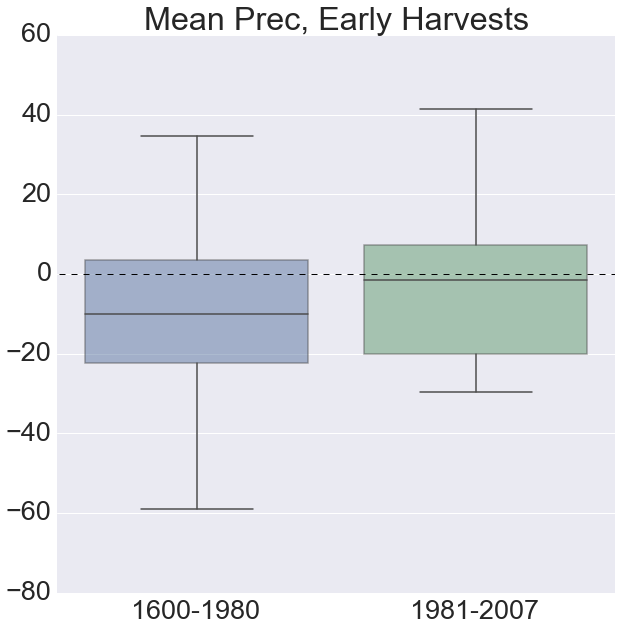

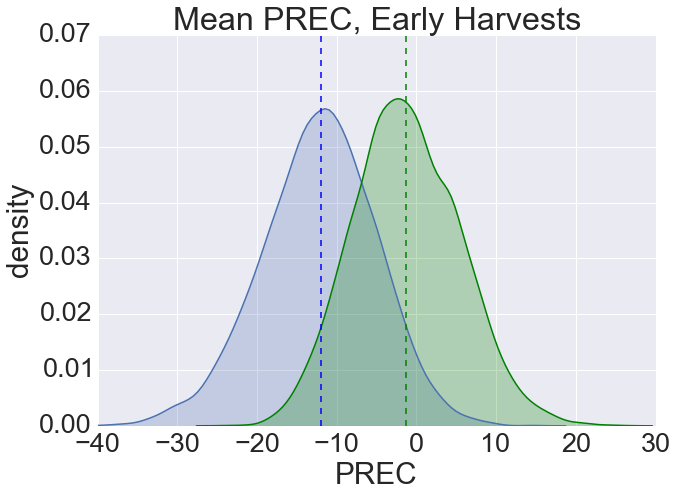

In [35]:
#%%############################################################################
# Prec Boxplot
sns.plt.close(); sns.set();
#sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
sns.set_context("notebook", font_scale=2.7, rc={"lines.linewidth": 1.5})
#fig = sns.plt.figure(figsize=(9,10))
fig = sns.plt.figure(figsize=(10,10))
sns.plt.plot([0,20],[0,0],'--', color='k',linewidth=1)
sns.boxplot([prec_before,prec_after], labels=[label_1, label_2], names=[group_before,group_after],alpha=0.5);
sns.plt.title('Mean Prec, Early Harvests')  
sns.plt.ylim(-80,60)
#sns.plt.tight_layout
sns.plt.savefig('../figures/step05/ghdcore.boxplot.prec.'+label_1[0]+'.'+label_2[0]+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 

#%%############################################################################
# Monte-Carlo

# Number of iterations
num_mc = 10000;

# I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
prec_resamp_mean_before = np.zeros(num_mc)
prec_resamp_mean_after  = np.zeros(num_mc)
pval_mc_prec_ttest2        = np.zeros(num_mc)
pval_mc_prec_ranksum       = np.zeros(num_mc)
pval_mc_precbefore_onesamp = np.zeros(num_mc)
pval_mc_precafter_onesamp  = np.zeros(num_mc)

# In each iteration, randomly resample (with replacement)
for i in np.arange(0,num_mc):
    
    #print(i)
    # First, Generate resampled PDSI for before and after periods
    prec_resamp_before = bootstrap_resample(prec_before,np.size(prec_after))
    prec_resamp_after  = bootstrap_resample(prec_after,np.size(prec_after))

    # Now, calculate and store the resampled means
    prec_resamp_mean_before[i] = np.mean(prec_resamp_before)
    prec_resamp_mean_after[i] = np.mean(prec_resamp_after)

    # Ttest and Ranksum tests
    pval_mc_prec_ttest2[i] = stats.ttest_ind(prec_resamp_before,prec_resamp_after)[1]
    pval_mc_prec_ranksum[i] = stats.ranksums(prec_resamp_before,prec_resamp_after)[1]
    pval_mc_precbefore_onesamp[i] = stats.ttest_1samp(prec_resamp_before,0)[1]
    pval_mc_precafter_onesamp[i]  = stats.ttest_1samp(prec_resamp_after,0)[1]
    
# Histogram Figure 
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=2.7, rc={"lines.linewidth": 1.5})
bins=np.arange(-2.5,1,.125)  
sns.plt.figure(figsize=[10,7])     
sns.kdeplot(prec_resamp_mean_before,shade=True)
sns.kdeplot(prec_resamp_mean_after,shade=True,color='g')
sns.plt.plot([np.mean(prec_before),np.mean(prec_before)],[0,.15],'--', color='b')
sns.plt.plot([np.mean(prec_after),np.mean(prec_after)],[0,.15],'--', color='g')
sns.plt.xlabel('PREC')
sns.plt.ylabel('density')
sns.plt.title('Mean PREC, Early Harvests')  
sns.plt.tight_layout
sns.plt.ylim(0,.07)
sns.plt.xlim(-40,30)
sns.plt.savefig('../figures/step05/ghdcore.montecarlo.prec.'+label_1[0]+'.'+label_2[0]+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 



In [22]:
# Summarize the Monte-Carlo Results

# Percent Simulations Where ttest and ranksum were significantly different
mc_ttest_sig   = np.size(np.where(pval_mc_prec_ttest2<=0.05))/np.size(pval_mc_prec_ttest2)
mc_ranksum_sig = np.size(np.where(pval_mc_prec_ranksum<=0.05))/np.size(pval_mc_prec_ranksum)
mc_before_zero_sig = np.size(np.where(pval_mc_precbefore_onesamp<=0.05))/np.size(pval_mc_precbefore_onesamp)
mc_after_zero_sig = np.size(np.where(pval_mc_precafter_onesamp<=0.05))/np.size(pval_mc_precafter_onesamp)

print('MC ttest='+np.str(mc_ttest_sig))
print('MC ranksum='+np.str(mc_ranksum_sig))
print('MC Prec Before vs 0='+np.str(mc_before_zero_sig))
print('MC Prec After vs 0='+np.str(mc_after_zero_sig))

# Initialize Matrix
percentiles_prec = np.zeros([2,5])

# Calculate Percentiles from the Monte-Carlo Simulation
percentiles_prec[0,:] =np.percentile(prec_resamp_mean_before,[1,5,50,95,99])
percentiles_prec[1,:] =np.percentile(prec_resamp_mean_after,[1,5,50,95,99])

# Create A DataFrame
col_core_comp_txt=["1st","5th","50th","95th","99th"]
row_core_comp_txt=[label_1[0],label_2[0]]
df_pctile_prec  = pd.DataFrame(percentiles_prec, index=row_core_comp_txt, columns=col_core_comp_txt)

print("Prec Percentiles, Monte-Carlo")
df_pctile_prec

MC ttest=0.1423
MC ranksum=0.0954
MC Prec Before vs 0=0.2985
MC Prec After vs 0=0.0785
Prec Percentiles, Monte-Carlo


,1st,5th,50th,95th,99th
1600-1980,-29.936606,-24.308992,-11.760131,-0.480756,3.735185
1981-2007,-15.665808,-12.149353,-1.566569,9.930172,15.417016


In [24]:
stats.ttest_1samp(prec_after,0)

(-0.18353218758975212, 0.8580484359878997)

In [138]:
#%%############################################################################
# Split Temp Series
temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs_before))==1)[0];  temp_before = tmpJJA_reg_mean_wt[temp_locs]
print("Early Years Before:")
print(yr_luter[temp_locs])

temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs_after))==1)[0];   temp_after  = tmpJJA_reg_mean_wt[temp_locs]
print("Early Years After:")
print(yr_luter[temp_locs])

#%%############################################################################
# Boxplot Labels
group_before = (np.str(yrs_before[0])+'-'+np.str(yrs_before[-1]));
group_after  = (np.str(yrs_after[0])+'-'+np.str(yrs_after[-1]));

label_1 = (np.tile(group_before,np.size(temp_before)))
label_2 = (np.tile(group_after,np.size(temp_after)))

#%%############################################################################
# Mean/Median Statistical Testing
# Initialize Matrix
mean_median_temp = np.zeros([3,3])

# Calculate the mean and median temp
mean_median_temp[0,0] = np.size(temp_before)
mean_median_temp[0,1] = np.size(temp_after)

mean_median_temp[1,0] = np.mean(temp_before)
mean_median_temp[1,1] = np.mean(temp_after)
mean_median_temp[1,2] = stats.ttest_ind(temp_before, temp_after)[1]

mean_median_temp[2,0] = np.median(temp_before)
mean_median_temp[2,1] = np.median(temp_after)
mean_median_temp[2,2] = stats.ranksums(temp_before, temp_after)[1]

# Create A DataFrame
col_core_comp_txt=[label_1[0],label_2[0],"Diff, Pval"]
row_core_comp_txt=["n","Mean Temp","Median Temp"]
df_prec_early_ghd  = pd.DataFrame(mean_median_temp, index=row_core_comp_txt, columns=col_core_comp_txt)

df_prec_early_ghd



Early Years Before:
[1602 1603 1604 1607 1610 1611 1615 1616 1619 1624 1630 1631 1636 1637 1638
 1639 1644 1645 1646 1651 1653 1657 1659 1660 1661 1665 1666 1668 1669 1671
 1676 1680 1681 1684 1686 1706 1718 1726 1788 1811 1822 1825 1834 1846 1862
 1865 1868 1870 1874 1893 1901 1904 1905 1906 1911 1915 1917 1921 1934 1937
 1943 1945 1947 1950 1952 1959 1960 1976]
Early Years After:
[1982 1989 1990 1992 1993 1994 1995 1997 1998 1999 2000 2001 2002]


,1600-1980,1981-2007,"Diff, Pval"
n,68.000000,13.000000,0.000000
Mean Temp,0.728157,0.973168,0.213111
Median Temp,0.635192,0.961259,0.168603


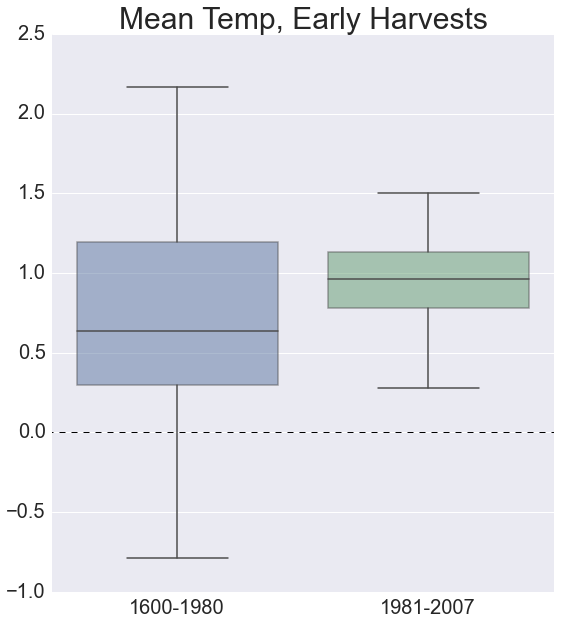

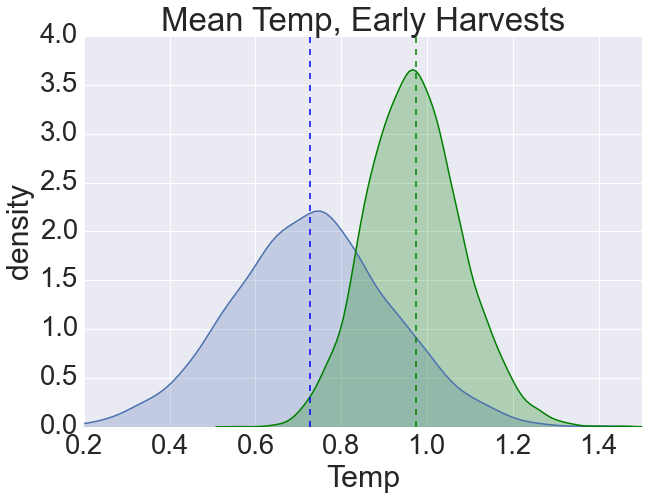

In [142]:
#%%############################################################################
# Temp Boxplot
sns.plt.close(); sns.set(); 
sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
fig = sns.plt.figure(figsize=(9,10))
sns.plt.plot([0,20],[0,0],'--', color='k',linewidth=1)
sns.boxplot([temp_before,temp_after], labels=[label_1, label_2], names=[group_before,group_after],alpha=0.5);
sns.plt.title('Mean Temp, Early Harvests')  
sns.plt.tight_layout
sns.plt.savefig('./figures/step06/ghdcore.boxplot.temp.'+label_1[0]+'.'+label_2[0]+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 

#%%############################################################################
# Monte-Carlo

# Number of iterations
num_mc = 10000;

# I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
temp_resamp_mean_before = np.zeros(num_mc)
temp_resamp_mean_after  = np.zeros(num_mc)
pval_mc_temp_ttest2        = np.zeros(num_mc)
pval_mc_temp_ranksum       = np.zeros(num_mc)
pval_mc_tempbefore_onesamp = np.zeros(num_mc)
pval_mc_tempafter_onesamp  = np.zeros(num_mc)

# In each iteration, randomly resample (with replacement)
for i in np.arange(0,num_mc):
    
    #print(i)
    # First, Generate resampled PDSI for before and after periods
    temp_resamp_before = bootstrap_resample(temp_before,np.size(temp_after))
    temp_resamp_after  = bootstrap_resample(temp_after,np.size(temp_after))

    # Now, calculate and store the resampled means
    temp_resamp_mean_before[i] = np.mean(temp_resamp_before)
    temp_resamp_mean_after[i] = np.mean(temp_resamp_after)

    # Ttest and Ranksum tests
    pval_mc_temp_ttest2[i] = stats.ttest_ind(temp_resamp_before,temp_resamp_after)[1]
    pval_mc_temp_ranksum[i] = stats.ranksums(temp_resamp_before,temp_resamp_after)[1]
    pval_mc_tempbefore_onesamp[i] = stats.ttest_1samp(temp_resamp_before,0)[1]
    pval_mc_tempafter_onesamp[i]  = stats.ttest_1samp(temp_resamp_after,0)[1]
    
# Histogram Figure 
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=2.75, rc={"lines.linewidth": 1.5})
bins=np.arange(-2.5,1,.125)  
sns.plt.figure(figsize=[10,7])     
sns.kdeplot(temp_resamp_mean_before,shade=True)
sns.kdeplot(temp_resamp_mean_after,shade=True,color='g')
sns.plt.plot([np.mean(temp_before),np.mean(temp_before)],[0,5],'--', color='b')
sns.plt.plot([np.mean(temp_after),np.mean(temp_after)],[0,5],'--', color='g')
sns.plt.xlabel('Temp')
sns.plt.ylabel('density')
sns.plt.title('Mean Temp, Early Harvests')  
sns.plt.tight_layout
sns.plt.ylim(0,4)
sns.plt.xlim(0.2,1.5)
sns.plt.savefig('./figures/step06/ghdcore.montecarlo.temp.'+label_1[0]+'.'+label_2[0]+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 




tt_prec= (-1.2551863438481967, 0.21311139268609722)
rs_prec= (-1.3767064337721961, 0.16860302879532341)


(0.4, 1.5)

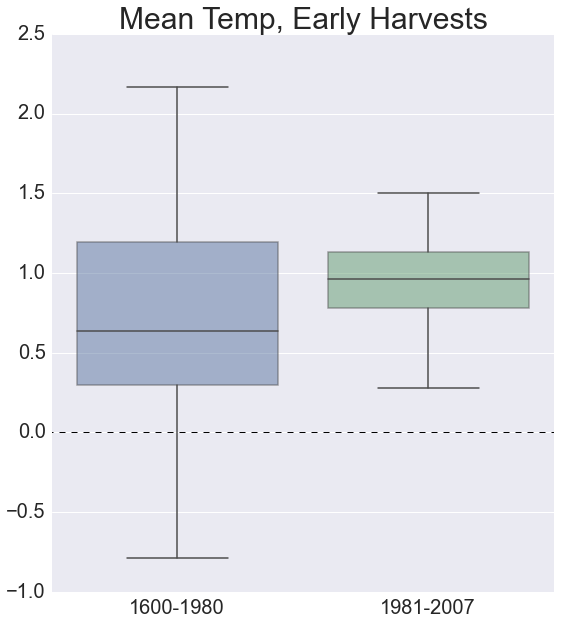

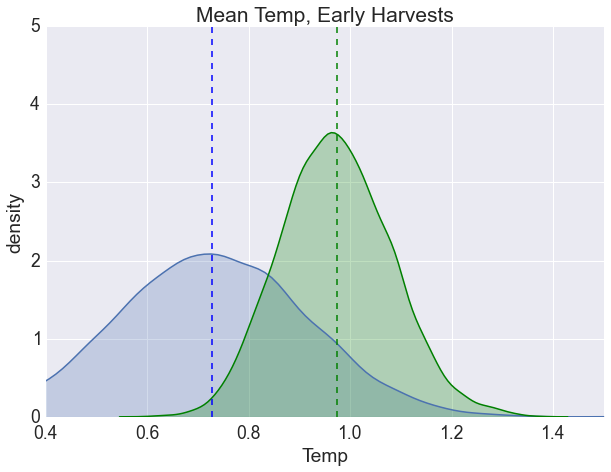

In [58]:
#%%############################################################################
# Now, find all years that exceed the threshold I set up before
early_yrs = yr[np.where(ghd_mean<=harvest_thresh)]

# Trim to eliminate years before 1600
remove_locs = np.where(early_yrs<1600)[0]
early_yrs = np.delete(early_yrs,remove_locs)

# Find Early Harvest Years that fall within this interval
subset_yrs_before  = np.intersect1d(yrs_before,early_yrs)
subset_yrs_after   = np.intersect1d(yrs_after,early_yrs)

#%%############################################################################
# Split PDSI Series
temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs_before))==1)[0];  temp_before = tmpJJA_reg_mean_wt[temp_locs]
temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs_after))==1)[0];   temp_after  = tmpJJA_reg_mean_wt[temp_locs]

# Statistical Testing
#help(stats.ttest_ind)
tt_temp = stats.ttest_ind(temp_before, temp_after)
print('tt_prec=',tt_temp)
rs_temp = stats.ranksums(temp_before, temp_after)
print('rs_prec=',rs_temp)

# Boxplot Labels
group_before = (np.str(yrs_before[0])+'-'+np.str(yrs_before[-1]));
group_after  = (np.str(yrs_after[0])+'-'+np.str(yrs_after[-1]));

label_1 = (np.tile(group_before,np.size(pdsi_before)))
label_2 = (np.tile(group_after,np.size(pdsi_after)))

#label_1 = (np.tile('1600-1950',np.size(pdsi_pre1950)))
#label_2 = (np.tile('1951-2007',np.size(pdsi_post1950)))

# PDSI Boxplot
sns.plt.close(); sns.set(); 
sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
fig = sns.plt.figure(figsize=(9,10))
#sns.plt.plot([0,20],[np.min(pdsi_post1950),np.min(pdsi_post1950)],'--', color='k')
sns.plt.plot([0,20],[0,0],'--', color='k',linewidth=1)
sns.boxplot([temp_before,temp_after], labels=[label_1, label_2], names=[group_before,group_after],alpha=0.5);
sns.plt.title('Mean Temp, Early Harvests')  
sns.plt.tight_layout
#sns.plt.savefig('./figures/step06/ghd.boxplot.pdsi.eps', format='eps', dpi=300) 
#sns.plt.savefig('./figures/step06/ghd.boxplot.pdsi.png', format='png', dpi=600) 
#sns.plt.savefig('./figures/step06/ghd.boxplot.pdsi.svg', format='svg', dpi=1200) 

#%%############################################################################
# Monte-Carlo

# Number of iterations
num_mc = 10000;

# I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
temp_resamp_mean_before = np.zeros(num_mc)
temp_resamp_mean_after  = np.zeros(num_mc)

# In each iteration, randomly resample (with replacement)
for i in np.arange(0,num_mc):
    
    #print(i)
    # First, Generate resampled PDSI for before and after periods
    temp_resamp_before = bootstrap_resample(temp_before,np.size(temp_after))
    temp_resamp_after  = bootstrap_resample(temp_after,np.size(temp_after))

    # Now, calculate and store the resampled means
    temp_resamp_mean_before[i] = np.mean(temp_resamp_before)
    temp_resamp_mean_after[i] = np.mean(temp_resamp_after)


# Histogram Figure 
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 1.5})
bins=np.arange(-2.5,1,.125)  
sns.plt.figure(figsize=[10,7])     
sns.kdeplot(temp_resamp_mean_before,shade=True)
sns.kdeplot(temp_resamp_mean_after,shade=True,color='g')
#sns.plt.hist(pdsi_synth, bins, normed=True, alpha=0.7);
sns.plt.plot([np.mean(temp_before),np.mean(temp_before)],[0,5],'--', color='b')
sns.plt.plot([np.mean(temp_after),np.mean(temp_after)],[0,5],'--', color='g')
sns.plt.xlabel('Temp')
sns.plt.ylabel('density')
sns.plt.title('Mean Temp, Early Harvests')  
sns.plt.tight_layout
sns.plt.ylim(0,5)
sns.plt.xlim(0.4,1.5)
#sns.plt.savefig('./figures/ghd_core_hist.'+legtxt_modern+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 







[  8.75018232 -18.66310444 -12.09838482  -9.70986657   8.20686806
   7.20308776 -37.94489036 -47.32403561  -2.45680082   9.33745675
 -37.01302478 -30.41884367   4.31060144  -4.45570069   2.27161403
  27.0861328   -3.71630677 -15.57964518  -1.99616772   3.11829788
 -20.99984523  -1.1430309   20.80871861 -12.2364533    5.05641391
  23.33517252 -63.00952827  28.72066726 -87.1353121   -9.26708432
 -42.05688265  10.24892683 -58.96682153 -43.98945849   1.1782421
 -70.2851281  -45.65198353 -34.64801541  -4.28857393   1.94167511
  -6.35164421 -23.19032123  17.52323452  -8.23355486   3.17972398
   7.4191068  -12.46357172 -23.59143171 -10.54353389 -16.24592519
 -13.06738777 -17.52746926  12.54083566 -47.70760192 -24.11569192
  -2.33859766  22.91786265 -20.77635143  -3.39920687 -22.19623465
 -10.86290812 -16.99852225 -19.19805932   4.01655835 -17.47451849
 -15.32390404  34.65834743 -30.99293056]

[ 14.2094504  -20.42813672 -19.52306819  41.32264945   0.21160925
  -8.44494113 -29.72332562  34.1782

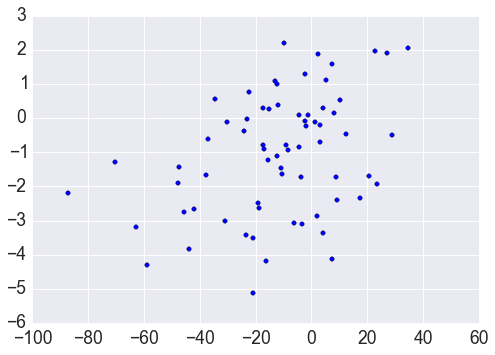

In [96]:
print(prec_before)
print("")
print(prec_after)
sns.plt.scatter(prec_before,pdsi_before)

(-2.5, 2.5)

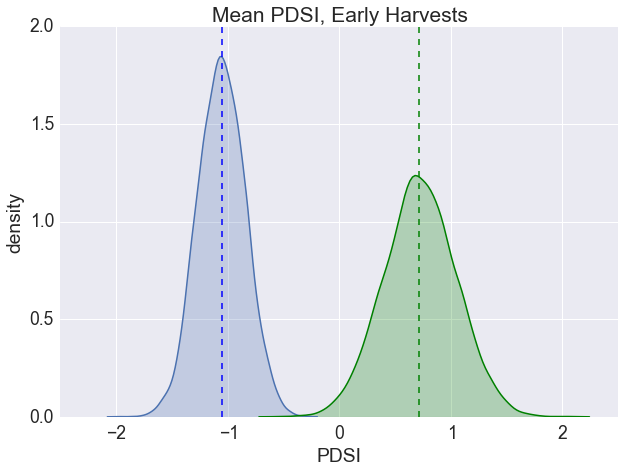

In [67]:
# Number of iterations
num_mc = 10000;

# I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
pdsi_resamp_mean_before = np.zeros(num_mc)
pdsi_resamp_mean_after  = np.zeros(num_mc)

# In each iteration, randomly resample (with replacement)
for i in np.arange(0,num_mc):
    
    #print(i)
    # First, Generate resampled PDSI for before and after periods
    pdsi_resamp_before = bootstrap_resample(pdsi_before,np.size(pdsi_before))
    pdsi_resamp_after  = bootstrap_resample(pdsi_after,np.size(pdsi_after))

    # Now, calculate and store the resampled means
    pdsi_resamp_mean_before[i] = np.mean(pdsi_resamp_before)
    pdsi_resamp_mean_after[i] = np.mean(pdsi_resamp_after)


# Histogram Figure 
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 1.5})
bins=np.arange(-2.5,1,.125)  
sns.plt.figure(figsize=[10,7])     
sns.kdeplot(pdsi_resamp_mean_before,shade=True)
sns.kdeplot(pdsi_resamp_mean_after,shade=True,color='g')
#sns.plt.hist(pdsi_synth, bins, normed=True, alpha=0.7);
sns.plt.plot([np.mean(pdsi_before),np.mean(pdsi_before)],[0,2],'--', color='b')
sns.plt.plot([np.mean(pdsi_after),np.mean(pdsi_after)],[0,2],'--', color='g')
sns.plt.xlabel('PDSI')
sns.plt.ylabel('density')
sns.plt.title('Mean PDSI, Early Harvests')  
sns.plt.tight_layout
sns.plt.ylim(0,2)
sns.plt.xlim(-2.5,2.5)
#sns.plt.savefig('./figures/ghd_core_hist.'+legtxt_modern+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 





    
    
    

In [57]:
pdsi_resamp_mean_before = np.zeros(num_mc)
pdsi_resamp_mean_after  = np.zeros(num_mc)

print(num_mc)
np.size(pdsi_resamp_before)

#help(np.zeros)

10000


68

In [ ]:
# Monte Carlo Simulation-PDSI

# Number of iterations
num_mc = 1000;

# I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
temp_synth = np.zeros(num_mc)
temp_post  = np.zeros(num_mc)

# In each iteration, randomly resample (with replacement)
for i in np.arange(0,1000):
    
    # First, Resample from the 'before' period
    resamp   = np.mean(bootstrap_resample(pdsi_before,np.size(pdsi_before)))
    temp_synth[i] = temp_new
    
    temp_new   = np.mean(bootstrap_resample(early_tmpJJA_post1950,np.size(early_tmpJJA_post1950)))
    temp_post[i] = temp_new
    
    # Resample with replacement
#    pdsi_new   = np.mean(bootstrap_resample(early_pdsi_all,np.size(early_pdsi_post1950)))
    temp_new   = np.mean(bootstrap_resample(early_tmpJJA_pre1950,np.size(early_tmpJJA_pre1950)))
    temp_synth[i] = temp_new
    
    temp_new   = np.mean(bootstrap_resample(early_tmpJJA_post1950,np.size(early_tmpJJA_post1950)))
    temp_post[i] = temp_new
    
# Histogram Figure 
bins=np.arange(-2.5,1,.125)  
sns.plt.figure(figsize=[10,7])     
sns.kdeplot(temp_synth,shade=True)
sns.kdeplot(temp_post,shade=True,color='r')
#sns.plt.hist(pdsi_synth, bins, normed=True, alpha=0.7);
sns.plt.plot([np.mean(early_tmpJJA_post1950),np.mean(early_tmpJJA_post1950)],[0,3],'--', color='r')
sns.plt.plot([np.mean(early_tmpJJA_pre1950),np.mean(early_tmpJJA_pre1950)],[0,3],'--', color='b')
sns.plt.xlabel('Temp')
sns.plt.ylabel('density')
sns.plt.title('Mean Temp, Early Harvests')  
sns.plt.tight_layout
sns.plt.ylim(0,3)
sns.plt.xlim(0,1.6)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
#sns.plt.savefig('./figures/ghd_core_hist.'+legtxt_modern+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 


















In [ ]:
#rc={'axes.labelsize': 32, 'font.size': 3, 'legend.fontsize': 3, 'axes.titlesize': 3}
#sns.axes_style(rc)
sns.plt.show()

#%%############################################################################
# Split Temp Series
temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs_pre1950))==1)[0]; tmpJJA_pre1950 = tmpJJA_reg_mean_wt[temp_locs]
temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs_post1950))==1)[0]; tmpJJA_post1950 = tmpJJA_reg_mean_wt[temp_locs]

# Statistical Testing
#help(stats.ttest_ind)
tt_temp = stats.ttest_ind(tmpJJA_pre1950, tmpJJA_post1950)
print('tt_temp=',tt_pdsi)
rs_pdsi = stats.ranksums(tmpJJA_pre1950, tmpJJA_post1950)
print('rs_temp=',rs_pdsi)

# Boxplot Labels
label_1 = (np.tile('1600-1950',np.size(tmpJJA_pre1950)))
label_2 = (np.tile('1951-2007',np.size(tmpJJA_post1950)))

# Temperature Boxplot
sns.plt.close(); sns.set(); 
sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
fig = sns.plt.figure(figsize=(9,10))
#sns.plt.plot([0,20],[np.min(pdsi_post1950),np.min(pdsi_post1950)],'--', color='k')
sns.plt.plot([0,20],[0,0],'--', color='k',linewidth=1)
sns.boxplot([tmpJJA_pre1950,tmpJJA_post1950], labels=[label_1, label_2], whis=np.inf, names=["1600-1950","1951-2007"],alpha=0.5);
sns.plt.title('Mean Temp (JJA), Early Harvests')  
sns.plt.tight_layout




#%%############################################################################
# Split Prec Series
prec_locs=np.where(np.int64(np.in1d(yr_paul,subset_yrs_pre1950))==1)[0]; tmpJJA_pre1950 = tmpJJA_reg_mean_wt[temp_locs]
temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs_post1950))==1)[0]; tmpJJA_post1950 = tmpJJA_reg_mean_wt[temp_locs]

# Statistical Testing
#help(stats.ttest_ind)
tt_temp = stats.ttest_ind(tmpJJA_pre1950, tmpJJA_post1950)
print('tt_temp=',tt_pdsi)
rs_pdsi = stats.ranksums(tmpJJA_pre1950, tmpJJA_post1950)
print('rs_temp=',rs_pdsi)

# Boxplot Labels
label_1 = (np.tile('1600-1950',np.size(tmpJJA_pre1950)))
label_2 = (np.tile('1951-2007',np.size(tmpJJA_post1950)))

# Temperature Boxplot
sns.plt.close(); sns.set(); 
sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
fig = sns.plt.figure(figsize=(9,10))
#sns.plt.plot([0,20],[np.min(pdsi_post1950),np.min(pdsi_post1950)],'--', color='k')
sns.plt.plot([0,20],[0,0],'--', color='k',linewidth=1)
sns.boxplot([tmpJJA_pre1950,tmpJJA_post1950], labels=[label_1, label_2], whis=np.inf, names=["1600-1950","1951-2007"],alpha=0.5);
sns.plt.title('Mean Temp (JJA), Early Harvests')  
sns.plt.tight_layout



#sns.plt.savefig('./figures/step06/ghd.boxplot.tempJJA.eps', format='eps', dpi=300) 
#sns.plt.savefig('./figures/step06/ghd.boxplot.tempJJA.png', format='png', dpi=600) 
#sns.plt.savefig('./figures/step06/ghd.boxplot.tempJJA.svg', format='svg', dpi=1200) 



#rc={'axes.labelsize': 32, 'font.size': 3, 'legend.fontsize': 3, 'axes.titlesize': 3}
#sns.axes_style(rc)



#sns.plt.get(fig,property="axes")

#sns.plt.acorr(pdsi_post1950)
#sns.plt.acorr(pdsi_pre1950)

#print((pdsi_post1950)); print((pdsi_pre1950))
#print(subset_yrs_pre1950)
#print(subset_yrs_post1950)
#sns.plt.plot(yr_luter,tmpJJA_reg_mean_wt)
#sns.plt.show()
#sns.plt.boxplot(pdsi_pre1950, names=["group1", "group1"], whis=np.inf, color="PaleGreen");
#sns.plt.show()
#fig = sns.plt.figure(figsize=(16,8))
#sns.plt.boxplot([pdsi_pre1950,, labels=["group1", "group1"], whis=np.inf, color="PaleGreen");
#sns.plt.show()

tt_pdsi= (-3.8160891280671518, 0.00025830977752854011)
rs_pdsi= (-3.4542605785031077, 0.00055180392838095438)


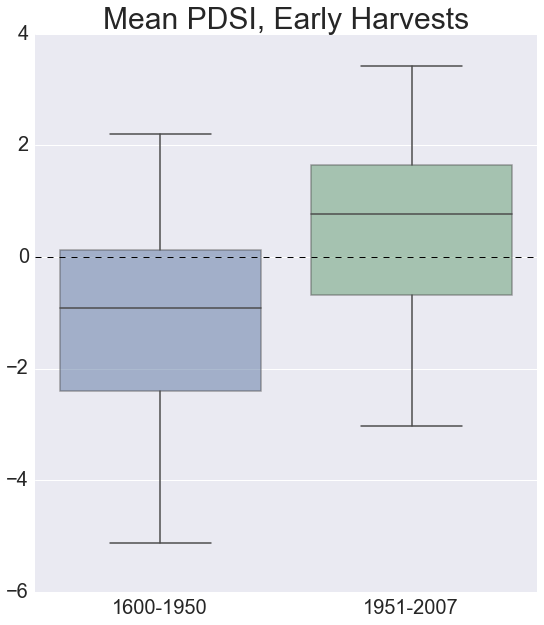

tt_temp= (-3.8160891280671518, 0.00025830977752854011)
rs_temp= (-1.728046869382702, 0.08397982178090474)


<function matplotlib.pyplot.tight_layout>

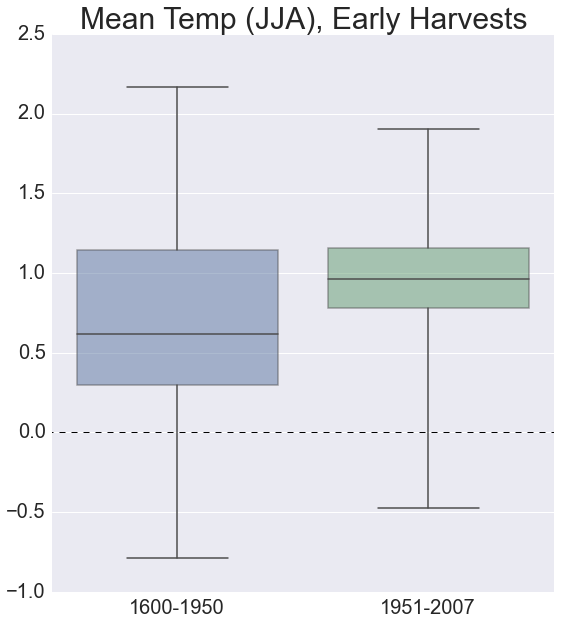

In [10]:
#%%############################################################################
# Now, find all years that exceed the threshold I set up before
early_yrs = yr[np.where(ghd_mean<=harvest_thresh)]

# Trim to eliminate years before 1600
remove_locs = np.where(early_yrs<1600)[0]
early_yrs = np.delete(early_yrs,remove_locs)

# Find Early Harvest Years that fall within this interval
subset_yrs_pre1950  = np.intersect1d(yr_samp_1600_1950,early_yrs)
subset_yrs_post1950 = np.intersect1d(yr_samp_1951_2007,early_yrs)

#%%############################################################################
# Split PDSI Series
pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs_pre1950))==1)[0]; pdsi_pre1950 = pdsi_reg_mean_wt[pdsi_locs]
pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs_post1950))==1)[0]; pdsi_post1950 = pdsi_reg_mean_wt[pdsi_locs]

# Statistical Testing
#help(stats.ttest_ind)
tt_pdsi = stats.ttest_ind(pdsi_pre1950, pdsi_post1950)
print('tt_pdsi=',tt_pdsi)
rs_pdsi = stats.ranksums(pdsi_pre1950, pdsi_post1950)
print('rs_pdsi=',rs_pdsi)

# Boxplot Labels
label_1 = (np.tile('1600-1950',np.size(pdsi_pre1950)))
label_2 = (np.tile('1951-2007',np.size(pdsi_post1950)))

# PDSI Boxplot
sns.plt.close(); sns.set(); 
sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
fig = sns.plt.figure(figsize=(9,10))
#sns.plt.plot([0,20],[np.min(pdsi_post1950),np.min(pdsi_post1950)],'--', color='k')
sns.plt.plot([0,20],[0,0],'--', color='k',linewidth=1)
sns.boxplot([pdsi_pre1950,pdsi_post1950], labels=[label_1, label_2], names=["1600-1950","1951-2007"],alpha=0.5);
sns.plt.title('Mean PDSI, Early Harvests')  
sns.plt.tight_layout
#sns.plt.savefig('./figures/step06/ghd.boxplot.pdsi.eps', format='eps', dpi=300) 
#sns.plt.savefig('./figures/step06/ghd.boxplot.pdsi.png', format='png', dpi=600) 
#sns.plt.savefig('./figures/step06/ghd.boxplot.pdsi.svg', format='svg', dpi=1200) 



#rc={'axes.labelsize': 32, 'font.size': 3, 'legend.fontsize': 3, 'axes.titlesize': 3}
#sns.axes_style(rc)
sns.plt.show()

#%%############################################################################
# Split Temp Series
temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs_pre1950))==1)[0]; tmpJJA_pre1950 = tmpJJA_reg_mean_wt[temp_locs]
temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs_post1950))==1)[0]; tmpJJA_post1950 = tmpJJA_reg_mean_wt[temp_locs]

# Statistical Testing
#help(stats.ttest_ind)
tt_temp = stats.ttest_ind(tmpJJA_pre1950, tmpJJA_post1950)
print('tt_temp=',tt_pdsi)
rs_pdsi = stats.ranksums(tmpJJA_pre1950, tmpJJA_post1950)
print('rs_temp=',rs_pdsi)

# Boxplot Labels
label_1 = (np.tile('1600-1950',np.size(tmpJJA_pre1950)))
label_2 = (np.tile('1951-2007',np.size(tmpJJA_post1950)))

# Temperature Boxplot
sns.plt.close(); sns.set(); 
sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
fig = sns.plt.figure(figsize=(9,10))
#sns.plt.plot([0,20],[np.min(pdsi_post1950),np.min(pdsi_post1950)],'--', color='k')
sns.plt.plot([0,20],[0,0],'--', color='k',linewidth=1)
sns.boxplot([tmpJJA_pre1950,tmpJJA_post1950], labels=[label_1, label_2], whis=np.inf, names=["1600-1950","1951-2007"],alpha=0.5);
sns.plt.title('Mean Temp (JJA), Early Harvests')  
sns.plt.tight_layout
#sns.plt.savefig('./figures/step06/ghd.boxplot.tempJJA.eps', format='eps', dpi=300) 
#sns.plt.savefig('./figures/step06/ghd.boxplot.tempJJA.png', format='png', dpi=600) 
#sns.plt.savefig('./figures/step06/ghd.boxplot.tempJJA.svg', format='svg', dpi=1200) 



#rc={'axes.labelsize': 32, 'font.size': 3, 'legend.fontsize': 3, 'axes.titlesize': 3}
#sns.axes_style(rc)



#sns.plt.get(fig,property="axes")

#sns.plt.acorr(pdsi_post1950)
#sns.plt.acorr(pdsi_pre1950)

#print((pdsi_post1950)); print((pdsi_pre1950))
#print(subset_yrs_pre1950)
#print(subset_yrs_post1950)
#sns.plt.plot(yr_luter,tmpJJA_reg_mean_wt)
#sns.plt.show()
#sns.plt.boxplot(pdsi_pre1950, names=["group1", "group1"], whis=np.inf, color="PaleGreen");
#sns.plt.show()
#fig = sns.plt.figure(figsize=(16,8))
#sns.plt.boxplot([pdsi_pre1950,, labels=["group1", "group1"], whis=np.inf, color="PaleGreen");
#sns.plt.show()




In [152]:
np.median(tmpJJA_post1950)

0.96162368418910527

In [ ]:
# Monte Carlo Stuff-PDSI

# Trim PDSI and GHD to overlapping intervals
overlap_pdsi = pdsi_reg_mean_wt[np.where((yr_pdsi>=1600) & (yr_pdsi<=2007))[0]]
overlap_ghd  = ghd_mean[np.where((yr>=1600) & (yr<=2007))[0]]
overlap_yr   = yr[np.where((yr>=1600) & (yr<=2007))[0]]

# Calculate composite PDSI for early years for different intervals
i_early = np.where((overlap_ghd<=harvest_thresh))[0];                      early_pdsi_all      = overlap_pdsi[i_early]
i_early = np.where((overlap_yr<=1950) & (overlap_ghd<=harvest_thresh))[0]; early_pdsi_pre1950  = overlap_pdsi[i_early]
i_early = np.where((overlap_yr>=1951) & (overlap_ghd<=harvest_thresh))[0]; early_pdsi_post1950 = overlap_pdsi[i_early]

# Monte Carlo. I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
pdsi_resamp_all     = np.zeros(1000)
pdsi_resamp_pre1950 = np.zeros(1000)
pdsi_resamp_post1950 = np.zeros(1000)

for i in np.arange(0,1000):
    
    # Resample with replacement
    pdsi_resamp_all[i]     = np.mean(bootstrap_resample(early_pdsi_all,np.size(early_pdsi_post1950)))
    pdsi_resamp_pre1950[i] = np.mean(bootstrap_resample(early_pdsi_pre1950,np.size(early_pdsi_post1950)))
    pdsi_resamp_post1950[i] = np.mean(bootstrap_resample(early_pdsi_post1950,np.size(early_pdsi_post1950)))

# Boxplot Figure 
fig = sns.plt.figure(figsize=(16,8))
bins=np.arange(-2.5,1,.125) 
sns.color_palette("Set2") 
sns.plt.figure(figsize=[10,7])     
#sns.distplot(pdsi_resamp_pre1950,shade=True) #alpha=0.1)
sns.kdeplot(pdsi_resamp_pre1950,shade=True) #alpha=0.1)
sns.kdeplot(pdsi_resamp_post1950,shade=True,color='r') #alpha=0.1)
#sns.kdeplot(pdsi_resamp_all,shade=True) #alpha=0.1)
sns.plt.plot([np.mean(early_pdsi_post1950),np.mean(early_pdsi_post1950)],[0,1.2],'--', color='r')
sns.plt.plot([np.mean(early_pdsi_pre1950),np.mean(early_pdsi_pre1950)],[0,1.2],'--', color='b')
sns.plt.xlabel('PDSI')
sns.plt.ylabel('density')
sns.plt.title('Mean PDSI, Early Harvests')  
sns.plt.tight_layout
sns.plt.ylim(0,1.2)
sns.plt.xlim(-2.5,2.5)
sns.plt.show()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
#sns.plt.savefig('./figures/ghd_core_hist.'+legtxt_modern+'.svg', format='svg', dpi=1200) 
# vector graphics for adobe illustrator 


# Histogram Figure 
fig = sns.plt.figure(figsize=(16,8))
bins=np.arange(-2.5,1,.125) 
sns.color_palette("Set2") 
sns.plt.figure(figsize=[10,7])     
#sns.distplot(pdsi_resamp_pre1950,shade=True) #alpha=0.1)
sns.kdeplot(pdsi_resamp_pre1950,shade=True) #alpha=0.1)
sns.kdeplot(pdsi_resamp_post1950,shade=True,color='r') #alpha=0.1)
#sns.kdeplot(pdsi_resamp_all,shade=True) #alpha=0.1)
sns.plt.plot([np.mean(early_pdsi_post1950),np.mean(early_pdsi_post1950)],[0,1.2],'--', color='r')
sns.plt.plot([np.mean(early_pdsi_pre1950),np.mean(early_pdsi_pre1950)],[0,1.2],'--', color='b')
sns.plt.xlabel('PDSI')
sns.plt.ylabel('density')
sns.plt.title('Mean PDSI, Early Harvests')  
sns.plt.tight_layout
sns.plt.ylim(0,1.2)
sns.plt.xlim(-2.5,2.5)
sns.plt.show()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
#sns.plt.savefig('./figures/ghd_core_hist.'+legtxt_modern+'.svg', format='svg', dpi=1200) 
# vector graphics for adobe illustrator 



In [ ]:
# This script will composite years from the OWDA and Luterbacher climate 
# reconstructions based on some threshold (defined) anomaly

#%%############################################################################
# Setup the Analysis
import calendar
import numpy as np
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from mpl_toolkits.basemap import Basemap, cm
#sns.set(palette="Set5")

# For plotting a rectangle on the maps
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)

# Resampling function
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample


#%%############################################################################
# User defined variables

# Years to sample from
yr_samp = np.arange(1600,1951); yr_txt = '1600-1950';
yr_samp = np.arange(1951,2007); yr_txt = '1951-2007';
yr_samp = np.arange(1951,1981); yr_txt = '1951-1980';
yr_samp = np.arange(1981,2008); yr_txt = '1981-2007';

# Rectangle Boundaries
lonmin=-2; lonmax=8; latmin=43; latmax=51

# baseline period for anomaly calculation. Should be same as base period in setp01_proc_ghd.py
base_period = np.arange(1600,1901)   

# User defined variables
# Set threshold GHD anomaly for compositing
harvest_thresh = -7.8;  # about 1 standard deviation for GHDmean or GHD core
#harvest_thresh = -3.9;  # about 1/2 standard deviation for GHDmean or GHD core

# GHD Data to choose
#ghd_name = 'GHDmean'
ghd_name = 'GHDcore'
#ghd_name = 'Bur'

#%%############################################################################
# Load and properly format wine data
infile= './data/ghd_anom_doy.csv'   # Name of the original data file

df=pd.read_csv(infile)

# Pull out year and mean as float64
yr = np.int64(df.Year)
ghd_mean = np.float64(df[ghd_name])

# Calculate standard deviation over base period
loc=np.where((yr>=np.min(base_period)) & (yr<=np.max(base_period)))[0]
std_ghd = np.nanstd(ghd_mean[loc])

#%%############################################################################
# Load OWDA Data
ncfile_owda = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/OWDA/owda_hd_fix_500.nc')

# Load OWDA Variables
lat_pdsi=ncfile_owda.variables['lat'][:];
lon_pdsi=ncfile_owda.variables['lon'][:];
yr_pdsi=ncfile_owda.variables['time'][:];
pdsi=ncfile_owda.variables['pdsi'][:];

# Swap PDSI axes so orientation is correct: time, lat, lon
pdsi=np.swapaxes(pdsi,0,2)

ncfile_owda.close

#%%############################################################################
# Load Luterbacher Temp Data
ncfile_luter = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/LUTERTEMP/LuterbacherTemp.nc')

# Load Variables
lat_temp=ncfile_luter.variables['lat'][:];
lon_temp=ncfile_luter.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_luter = np.arange(1,5); seas_luter_all = np.transpose(np.tile(seas_luter,(1,503)))
yr_luter  = np.arange(1500,2003); # yr_luter_all = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# Now, pull out each season individually
tmp_locs = np.where(seas_luter_all==1); tmp_locs = tmp_locs[0]; tmp_DJF = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==2); tmp_locs = tmp_locs[0]; tmp_MAM = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==3); tmp_locs = tmp_locs[0]; tmp_JJA = ncfile_luter.variables['temp'][tmp_locs,0,:,:]
tmp_locs = np.where(seas_luter_all==4); tmp_locs = tmp_locs[0]; tmp_SON = ncfile_luter.variables['temp'][tmp_locs,0,:,:]

ncfile_luter.close

#%%############################################################################
# Load Pauling Precip Data
ncfile_pauling = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/PAULINGPREC/PaulingPrecip.nc')

# Load Variables
lat_temp=ncfile_luter.variables['lat'][:];
lon_temp=ncfile_luter.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_paul = np.arange(1,5); seas_paul_all = np.transpose(np.tile(seas_luter,(1,501)))
yr_paul  = np.arange(1500,2001); # yr_luter_all = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# Now, pull out each season individually
pre_locs = np.where(seas_paul_all==1); pre_locs = pre_locs[0]; pre_DJF = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==2); pre_locs = pre_locs[0]; pre_MAM = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==3); pre_locs = pre_locs[0]; pre_JJA = ncfile_pauling.variables['precip'][pre_locs,0,:,:]
pre_locs = np.where(seas_paul_all==4); pre_locs = pre_locs[0]; pre_SON = ncfile_pauling.variables['precip'][pre_locs,0,:,:]

ncfile_pauling.close

#%%############################################################################
# Anomalize temperature/precipitation data and recenter PDSI to same baseline as GHD anomalies

# Find PDSI years for this period and calculate mean
i_yr_pdsi = np.where( (yr_pdsi>=np.min(base_period)) & (yr_pdsi<=np.max(base_period))); i_yr_pdsi=i_yr_pdsi[0];
# Calculate Mean and recenter PDSI
base_mean_pdsi = np.mean(pdsi[i_yr_pdsi,:,:],axis=0)
pdsi_recenter=pdsi-base_mean_pdsi

# Calculate Mean and Anomalize Temperature
i_yr_temp = np.where( (yr_luter>=np.min(base_period)) & (yr_luter<=np.max(base_period))); i_yr_temp=i_yr_temp[0];
tmp_DJF_mean = np.mean(tmp_DJF[i_yr_temp,:,:],axis=0)
tmp_MAM_mean = np.mean(tmp_MAM[i_yr_temp,:,:],axis=0)
tmp_JJA_mean = np.mean(tmp_JJA[i_yr_temp,:,:],axis=0)
tmp_SON_mean = np.mean(tmp_SON[i_yr_temp,:,:],axis=0)

tmp_DJF_anom = tmp_DJF-tmp_DJF_mean
tmp_MAM_anom = tmp_MAM-tmp_MAM_mean
tmp_JJA_anom = tmp_JJA-tmp_JJA_mean
tmp_SON_anom = tmp_SON-tmp_SON_mean

# Calculate Mean and Anomalize precipitation
i_yr_prec = np.where( (yr_paul>=np.min(base_period)) & (yr_paul<=np.max(base_period))); i_yr_prec=i_yr_prec[0];
pre_DJF_mean = np.mean(pre_DJF[i_yr_prec,:,:],axis=0)
pre_MAM_mean = np.mean(pre_MAM[i_yr_prec,:,:],axis=0)
pre_JJA_mean = np.mean(pre_JJA[i_yr_prec,:,:],axis=0)
pre_SON_mean = np.mean(pre_SON[i_yr_prec,:,:],axis=0)

pre_DJF_anom = pre_DJF-pre_DJF_mean
pre_MAM_anom = pre_MAM-pre_MAM_mean
pre_JJA_anom = pre_JJA-pre_JJA_mean
pre_SON_anom = pre_SON-pre_SON_mean

#%%############################################################################
# Now, find all years that exceed the threshold I set up before
early_yrs = yr[np.where(ghd_mean<=harvest_thresh)]

# Trim to eliminate years before 1600
remove_locs = np.where(early_yrs<1600)[0]
early_yrs = np.delete(early_yrs,remove_locs)

#%%############################################################################
# PDSI Maps
subset_yrs = early_yrs[np.where(early_yrs<=1950)[0]];  pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0]; yr_txt='pre1950'
















#%%############################################################################
# PDSI Maps

# ALL Qualifying YEARS
#subset_yrs = early_yrs;                                pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0]; yr_txt='allyrs'
#subset_yrs = early_yrs[np.where(early_yrs<=1950)[0]];  pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0]; yr_txt='pre1950'
#subset_yrs = early_yrs[np.where(early_yrs>1950)[0]];   pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0]; yr_txt='post1950'
#subset_yrs = early_yrs[np.where(early_yrs>=1970)[0]];   pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0]; yr_txt='post1950'
#subset_yrs = early_yrs[np.where(early_yrs<=1950)[0]];  pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0]; yr_txt='pre1950'

subset_yrs = early_yrs[np.where(early_yrs<=1950)[0]];  pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0]; yr_txt='pre1950'
#subset_yrs = early_yrs[np.where(early_yrs>1950)[0]];   pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0]; yr_txt='post1950'

#subset_yrs = early_yrs[np.where((early_yrs>=1951) &  (early_yrs<=1980) )[0]];  pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0]; yr_txt='1951-1980'
#subset_yrs = early_yrs[np.where(early_yrs>=1981)[0]];  pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0]; yr_txt='1981'

# Composite Average
pdsi_comp_all = np.mean(pdsi_recenter[pdsi_locs,:,:],axis=0)

lon_map = lon_pdsi; lat_map = lat_pdsi;

#lonlim=np.array([np.min(lon_map),36]);
#latlim=np.array([30,np.max(lat_map)]);
lonlim=np.array([-10,16]);
latlim=np.array([35,60]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
#proj_txt='merc'     # Mercator projection
#proj_txt='mill'     # Miller cylindrical projection
#proj_txt='gall'     # Gall Stereographic Projection
#proj_txt='cea'       # Cylindrical equal area projection

lon_map, lat_map = np.meshgrid(lon_map, lat_map)

# MAP
# Title
#title_txt = ghd_name+', Spearman''s r, Temp ('+mons_ave_txt+')'
title_txt = ghd_name+', PDSI Comp, ('+np.str(np.size(pdsi_locs))+')'
fontdict = {'fontsize': 18}

# Map up composite
# Equidistant Cylindrical
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# equidistant cylindrical
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
#ny = data.shape[0]; nx = data.shape[1]
#lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# draw filled contours.
clevs = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
#clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
clevs=np.asarray(clevs); clevs=clevs*0.25
#cs = m.contourf(x,y,pdsi_comp_all,clevs,cmap=cm.GMT_drywet,extend="both")
cs = m.contourf(x,y,pdsi_comp_all,clevs,cmap=plt.cm.BrBG,extend="both")  # blue green to brown
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('PDSI',fontsize=18)
# add title
plt.title(title_txt,fontdict)
plt.show()
#out_txt = './figures/pdsi.comp.'+yr_txt+'.n'+np.str(np.size(pdsi_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.svg'
#fig.savefig(out_txt, format='svg', dpi=1200) # vector graphics for adobe illustrator 
out_txt = './figures/pdsi.comp.'+yr_txt+'.n'+np.str(np.size(pdsi_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.eps'
#fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator 

#%%############################################################################
# Temperature Maps

# Choose Season of Temperature
tmp_seas = tmp_JJA_anom; seas_txt='JJA';
#tmp_seas = tmp_MAM_anom; seas_txt='MAM';

# Choose Qualifying YEARS
#subset_yrs = early_yrs;                                temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs))==1)[0]; yr_txt='allyrs'
subset_yrs = early_yrs[np.where(early_yrs<=1950)[0]];  temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs))==1)[0]; yr_txt='pre1950'
#subset_yrs = early_yrs[np.where(early_yrs>1950)[0]];   temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs))==1)[0]; yr_txt='post1950'
#subset_yrs = early_yrs[np.where(early_yrs>=1970)[0]];   temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs))==1)[0]; yr_txt='post1950'

# Composite Average
tmp_comp_all = np.mean(tmp_seas[temp_locs,:,:],axis=0)

lon_map = lon_temp; lat_map = lat_temp;

# already set above
#lonlim=np.array([np.min(lon_map),36]);
#latlim=np.array([30,np.max(lat_map)]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
#proj_txt='merc'     # Mercator projection
#proj_txt='mill'     # Miller cylindrical projection
#proj_txt='gall'     # Gall Stereographic Projection
#proj_txt='cea'       # Cylindrical equal area projection

lon_map, lat_map = np.meshgrid(lon_map, lat_map)

# MAP
# Title
#title_txt = ghd_name+', Spearman''s r, Temp ('+mons_ave_txt+')'
title_txt = ghd_name+', Temp Comp, ('+np.str(np.size(temp_locs))+')'
fontdict = {'fontsize': 18}

# Map up correlation
# Equidistant Cylindrical
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# equidistant cylindrical
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
#ny = data.shape[0]; nx = data.shape[1]
#lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# draw filled contours.
clevs = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
#clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
clevs=np.asarray(clevs); clevs=clevs*0.25
cs = m.contourf(x,y,tmp_comp_all,clevs,cmap=plt.cm.RdBu_r,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('deg C',fontsize=18)
# add title
plt.title(title_txt,fontdict)
plt.show()
#out_txt = './figures/temp.comp.'+seas_txt+'.'+yr_txt+'.n'+np.str(np.size(temp_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.svg'
#fig.savefig(out_txt, format='svg', dpi=1200) # vector graphics for adobe illustrator 
out_txt = './figures/temp.comp.'+seas_txt+'.'+yr_txt+'.n'+np.str(np.size(temp_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.eps'
#fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator 

#%%############################################################################
# Calculate regional average PDSI

# Lat and lon indices for the specified region
i_lon_reg=np.where((lon_pdsi>=lonmin) & (lon_pdsi<=lonmax))[0]
i_lat_reg=np.where((lat_pdsi>=latmin) & (lat_pdsi<=latmax))[0]

# Latitude and Longitude Indices for this region
lon_reg = lon_pdsi[i_lon_reg]
lat_reg = lat_pdsi[i_lat_reg]

# Create Latitude Weights
lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)

pdsi_reg_mean=np.zeros(np.size(yr_pdsi))
pdsi_reg_mean_wt=np.zeros(np.size(yr_pdsi))

# Loop Through Each Year
for i in enumerate(yr_pdsi):
    # Pull Correlations From This Region
    region_pdsi = pdsi_recenter[i[0],i_lat_reg,:][:,i_lon_reg]

    # Unweighted and Weighted Means
    pdsi_reg_mean[i[0]]    = np.ma.average(np.ma.masked_invalid(region_pdsi))
    pdsi_reg_mean_wt[i[0]] = np.ma.average(np.ma.masked_invalid(region_pdsi),weights=lat_wts_grid)

#%%############################################################################
# Calculate regional average Temperature

# Lat and lon indices for the specified region
i_lon_reg=np.where((lon_temp>=lonmin) & (lon_temp<=lonmax))[0]
i_lat_reg=np.where((lat_temp>=latmin) & (lat_temp<=latmax))[0]

# Latitude and Longitude Indices for this region
lon_reg = lon_temp[i_lon_reg]
lat_reg = lat_temp[i_lat_reg]

# Create Latitude Weights
lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)

tmpJJA_reg_mean=np.zeros(np.size(yr_luter))
tmpJJA_reg_mean_wt=np.zeros(np.size(yr_luter))

# Loop Through Each Year
for i in enumerate(yr_luter):
    # Pull Correlations From This Region
    region_temp = tmp_JJA_anom[i[0],i_lat_reg,:][:,i_lon_reg]

    # Unweighted and Weighted Means
    tmpJJA_reg_mean[i[0]]    = np.ma.average(np.ma.masked_invalid(region_temp))
    tmpJJA_reg_mean_wt[i[0]] = np.ma.average(np.ma.masked_invalid(region_temp),weights=lat_wts_grid)

#%%############################################################################
# Overlapping Intervals: GHD, PDSI, and temp
# overlap_pdsi = pdsi_reg_mean_wt[np.where((yr_pdsi>=1600) & (yr_pdsi<=2002))[0]]
# overlap_temp = tmpJJA_reg_mean_wt[np.where((yr_luter>=1600) & (yr_luter<=2002))[0]]
# overlap_ghd  = ghd_mean[np.where((yr>=1600) & (yr<=2002))[0]]

# Output for Lizzie
pdsi_df=pd.DataFrame(pd.TimeSeries(pdsi_reg_mean_wt))
pdsi_df.index=yr_pdsi
pdsi_df.to_csv('pdsi_area_ave.csv',sep=',')

temp_df=pd.DataFrame(pd.TimeSeries(tmpJJA_reg_mean_wt))
temp_df.index=yr_luter
temp_df.to_csv('tmpJJA_area_ave.csv',sep=',')

ghd_df=pd.DataFrame(pd.TimeSeries(ghd_mean))
ghd_df.index=yr
ghd_df.to_csv('ghd_core_index.csv',sep=',')

#%%############################################################################
# Monte Carlo Stuff-PDSI

#harvest_thresh=-7

# Trim PDSI and GHD to overlapping intervals
overlap_pdsi = pdsi_reg_mean_wt[np.where((yr_pdsi>=1600) & (yr_pdsi<=2007))[0]]
overlap_ghd  = ghd_mean[np.where((yr>=1600) & (yr<=2007))[0]]
overlap_yr   = yr[np.where((yr>=1600) & (yr<=2007))[0]]

# Calculate composite PDSI for early years for different intervals
i_early = np.where((overlap_ghd<=harvest_thresh))[0];                      early_pdsi_all      = overlap_pdsi[i_early]
i_early = np.where((overlap_yr<=1950) & (overlap_ghd<=harvest_thresh))[0]; early_pdsi_pre1950  = overlap_pdsi[i_early]
i_early = np.where((overlap_yr>=1951) & (overlap_ghd<=harvest_thresh))[0]; early_pdsi_post1950 = overlap_pdsi[i_early]

# Monte Carlo. I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
pdsi_resamp_all     = np.zeros(1000)
pdsi_resamp_pre1950 = np.zeros(1000)
pdsi_resamp_post1950 = np.zeros(1000)

for i in np.arange(0,1000):
    
    # Resample with replacement
    pdsi_resamp_all[i]     = np.mean(bootstrap_resample(early_pdsi_all,np.size(early_pdsi_post1950)))
    pdsi_resamp_pre1950[i] = np.mean(bootstrap_resample(early_pdsi_pre1950,np.size(early_pdsi_post1950)))
    pdsi_resamp_post1950[i] = np.mean(bootstrap_resample(early_pdsi_post1950,np.size(early_pdsi_post1950)))

# Histogram Figure 
bins=np.arange(-2.5,1,.125) 
sns.color_palette("Set2") 
sns.plt.figure(figsize=[10,7])     
#sns.distplot(pdsi_resamp_pre1950,shade=True) #alpha=0.1)
sns.kdeplot(pdsi_resamp_pre1950,shade=True) #alpha=0.1)
sns.kdeplot(pdsi_resamp_post1950,shade=True,color='r') #alpha=0.1)
#sns.kdeplot(pdsi_resamp_all,shade=True) #alpha=0.1)
sns.plt.plot([np.mean(early_pdsi_post1950),np.mean(early_pdsi_post1950)],[0,1.2],'--', color='r')
sns.plt.plot([np.mean(early_pdsi_pre1950),np.mean(early_pdsi_pre1950)],[0,1.2],'--', color='b')
sns.plt.xlabel('PDSI')
sns.plt.ylabel('density')
sns.plt.title('Mean PDSI, Early Harvests')  
sns.plt.tight_layout
sns.plt.ylim(0,1.2)
sns.plt.xlim(-2.5,2.5)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
#sns.plt.savefig('./figures/ghd_core_hist.'+legtxt_modern+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 

#%%############################################################################
# Monte Carlo Stuff-TEMP

#harvest_thresh=-7

# Trim PDSI and GHD to overlapping intervals
overlap_temp = tmpJJA_reg_mean_wt[np.where((yr_luter>=1600) & (yr_luter<=2002))[0]]
overlap_ghd  = ghd_mean[np.where((yr>=1600) & (yr<=2002))[0]]
overlap_yr   = yr[np.where((yr>=1600) & (yr<=2002))[0]]

# Calculate composite PDSI for early years for different intervals
i_early = np.where((overlap_ghd<=harvest_thresh))[0];                      early_tmpJJA_all      = overlap_temp[i_early]
i_early = np.where((overlap_yr<=1950) & (overlap_ghd<=harvest_thresh))[0]; early_tmpJJA_pre1950  = overlap_temp[i_early]
i_early = np.where((overlap_yr>=1951) & (overlap_ghd<=harvest_thresh))[0]; early_tmpJJA_post1950 = overlap_temp[i_early]

# Monte Carlo. I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
temp_synth = np.zeros(1000)
temp_post  = np.zeros(1000)

for i in np.arange(0,1000):
    
    # Resample with replacement
#    pdsi_new   = np.mean(bootstrap_resample(early_pdsi_all,np.size(early_pdsi_post1950)))
    temp_new   = np.mean(bootstrap_resample(early_tmpJJA_pre1950,np.size(early_tmpJJA_pre1950)))
    temp_synth[i] = temp_new
    
    temp_new   = np.mean(bootstrap_resample(early_tmpJJA_post1950,np.size(early_tmpJJA_post1950)))
    temp_post[i] = temp_new
    
# Histogram Figure 
bins=np.arange(-2.5,1,.125)  
sns.plt.figure(figsize=[10,7])     
sns.kdeplot(temp_synth,shade=True)
sns.kdeplot(temp_post,shade=True,color='r')
#sns.plt.hist(pdsi_synth, bins, normed=True, alpha=0.7);
sns.plt.plot([np.mean(early_tmpJJA_post1950),np.mean(early_tmpJJA_post1950)],[0,3],'--', color='r')
sns.plt.plot([np.mean(early_tmpJJA_pre1950),np.mean(early_tmpJJA_pre1950)],[0,3],'--', color='b')
sns.plt.xlabel('Temp')
sns.plt.ylabel('density')
sns.plt.title('Mean Temp, Early Harvests')  
sns.plt.tight_layout
sns.plt.ylim(0,3)
sns.plt.xlim(0,1.6)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
#sns.plt.savefig('./figures/ghd_core_hist.'+legtxt_modern+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 





